In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

from gnnad.graphanomaly import GNNAD
from gnnad.generate import GenerateGaussian, GenerateAnomaly

c:\Users\n10907700\Anaconda3\envs\gdn_old\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


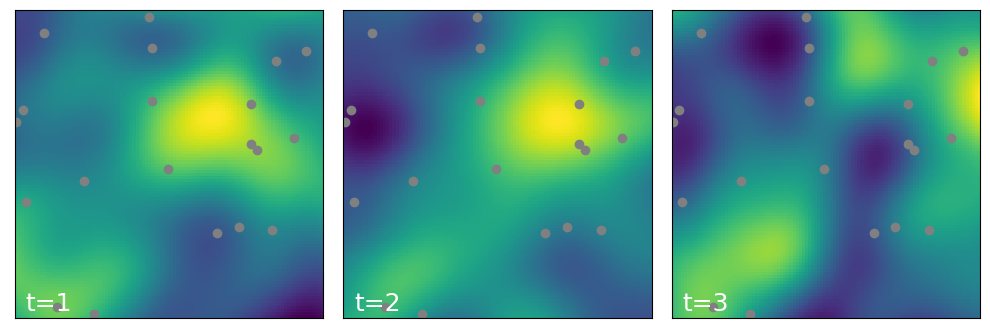

In [2]:
# generate data
gengauss = GenerateGaussian()
X = gengauss.generate()
gengauss.field_plot()


In [3]:
# split train test
X_train, X_test = train_test_split(X, shuffle=False)

# generate anomalies on test set
anoms = GenerateAnomaly(X_test)
X_test = anoms.generate_anomaly(anoms.variability, lam = 3, prop_anom = 0.07, seed=45)
X_test = anoms.generate_anomaly(anoms.drift, lam = 11, prop_anom = 0.07, seed=234)
y_test = anoms.get_labels()

# TODO: plot input data

In [9]:
# run model
model = GNNAD(threshold_type="max_validation", slide_win=3, topk=5)
fitted_model = model.fit(X_train, X_test, y_test)


epoch (0 / 100) (Loss:0.49866599, ACU_loss:0.49866599)
epoch (1 / 100) (Loss:0.48463464, ACU_loss:0.48463464)
epoch (2 / 100) (Loss:0.44974670, ACU_loss:0.44974670)
epoch (3 / 100) (Loss:0.42365110, ACU_loss:0.42365110)
epoch (4 / 100) (Loss:0.42416009, ACU_loss:0.42416009)
epoch (5 / 100) (Loss:0.41123047, ACU_loss:0.41123047)
epoch (6 / 100) (Loss:0.39838949, ACU_loss:0.39838949)
epoch (7 / 100) (Loss:0.39617002, ACU_loss:0.39617002)
epoch (8 / 100) (Loss:0.37992632, ACU_loss:0.37992632)
epoch (9 / 100) (Loss:0.36777002, ACU_loss:0.36777002)
epoch (10 / 100) (Loss:0.35663965, ACU_loss:0.35663965)
epoch (11 / 100) (Loss:0.36666715, ACU_loss:0.36666715)
epoch (12 / 100) (Loss:0.33530566, ACU_loss:0.33530566)
epoch (13 / 100) (Loss:0.34539476, ACU_loss:0.34539476)
epoch (14 / 100) (Loss:0.34006518, ACU_loss:0.34006518)
epoch (15 / 100) (Loss:0.32655519, ACU_loss:0.32655519)
=========================** Result **============================

F1 score: 0.30303030303030304
precision: 0.1807

In [ ]:
# TODO: plot results 